# Downloading Dataset using Kaggle API

In [2]:
import opendatasets as od

od.download(
	"https://www.kaggle.com/c/state-farm-distracted-driver-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mindhawk
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 4.00G/4.00G [40:01<00:00, 1.79MB/s]



Extracting archive .\state-farm-distracted-driver-detection/state-farm-distracted-driver-detection.zip to .\state-farm-distracted-driver-detection


# Importing Required Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, Reshape, Dropout
from sklearn.model_selection import train_test_split
import os
import shutil
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Splitting Data into Train and Test Directories

In [2]:
file_path = 'state-farm-distracted-driver-detection//driver_imgs_list.csv'
df = pd.read_csv(file_path)
df.head(2)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg


In [3]:
# Path to the original dataset directory
source_dir = 'state-farm-distracted-driver-detection\\imgs\\train\\'
train_dir = 'state-farm-distracted-driver-detection\\data\\train\\'
test_dir = 'state-farm-distracted-driver-detection\\data\\test\\'

# Create directories for split data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split dataset by subject (driver ID)
# Grouping by 'subject' ensures drivers in the test set are unseen during training
unique_subjects = df['subject'].unique()
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Separate data into train and test based on subjects
train_data = df[df['subject'].isin(train_subjects)]
test_data = df[df['subject'].isin(test_subjects)]

# Function to copy images to target directories
def copy_images(data, target_dir):
    for _, row in data.iterrows():
        classname = row['classname']
        img_name = row['img']
        source_path = os.path.join(source_dir, classname, img_name)
        target_class_dir = os.path.join(target_dir, classname)
        os.makedirs(target_class_dir, exist_ok=True)
        if os.path.exists(source_path):  # Ensure the file exists before copying
            shutil.copy(source_path, os.path.join(target_class_dir, img_name))

# Copy images to train and test directories
copy_images(train_data, train_dir)
copy_images(test_data, test_dir)

# Verify results
len(os.listdir(train_dir)), len(os.listdir(test_dir))

(10, 10)

# Creating Training and Testing ImageDataGenerator

In [4]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [5]:
train_dir = 'state-farm-distracted-driver-detection\\data\\train\\'
test_dir = 'state-farm-distracted-driver-detection\\data\\test\\'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
                                                        train_dir,
                                                        target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode = 'categorical',
                                                        batch_size = 128
                                                    )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
                                                        test_dir,
                                                        target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode = 'categorical',
                                                        batch_size = 128
                                                    )

Found 17446 images belonging to 10 classes.
Found 4978 images belonging to 10 classes.


# Creating a Sequential Model (Self-Implementation)

In [3]:
regularizer = tf.keras.regularizers.l2(l2=0.01) # l2 regularization to penalize larger mistakes, meanwhile ignoring smaller mistakes.
self_model = tf.keras.models.Sequential([
    Input((224, 224, 3)),
    Conv2D(8, (3,3), activation = 'relu', kernel_regularizer=regularizer),# input_shape = (224, 224, 3),
    MaxPooling2D(2, 2),
    Conv2D(16, (3,3), activation = 'relu', kernel_regularizer=regularizer),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation = 'relu', kernel_regularizer=regularizer),
    MaxPooling2D(2, 2),
    Flatten(), # Flatten output from conv2D layer, for Dense Layer
    Dense(units = 1024, activation = 'relu'),
    Dense(units = 10, activation = 'softmax') # Output in 10 classes
])

self_model.compile(optimizer = Adam(learning_rate = 0.00005), loss = 'categorical_crossentropy', metrics = ['accuracy'])
self_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [4]:
# Use ceckpoint, to ensure best fit to be used after all epochs
checkpoint = ModelCheckpoint("self_1.keras", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# Early Stop, to stop training, incase no change in accuracy
early = EarlyStopping(monitor='accuracy', min_delta=0.005, patience=2, verbose=1, mode='auto')

self_model.fit(train_generator, epochs= 100, callbacks=[checkpoint,early])
self_model.save_weights("self_1.keras")

Epoch 1/100
176/176 [==============================] - 283s 2s/step - loss: 2.6240 - accuracy: 0.1357

Epoch 00001: accuracy improved from -inf to 0.13566, saving model to self_1.keras
Epoch 2/100
176/176 [==============================] - 284s 2s/step - loss: 2.5299 - accuracy: 0.1806

Epoch 00002: accuracy improved from 0.13566 to 0.18057, saving model to self_1.keras
Epoch 3/100
176/176 [==============================] - 305s 2s/step - loss: 2.4582 - accuracy: 0.2042

Epoch 00003: accuracy improved from 0.18057 to 0.20420, saving model to self_1.keras
Epoch 4/100
176/176 [==============================] - 308s 2s/step - loss: 2.3932 - accuracy: 0.2339

Epoch 00004: accuracy improved from 0.20420 to 0.23390, saving model to self_1.keras
Epoch 5/100
176/176 [==============================] - 297s 2s/step - loss: 2.3268 - accuracy: 0.2623

Epoch 00005: accuracy improved from 0.23390 to 0.26226, saving model to self_1.keras
Epoch 6/100
176/176 [==============================] - 308s 2s/

# Storing a Model
model.save("my_model.h5", include_optimizer=True)


# Loading a Model
model = tf.keras.models.load_model("my_model.h5")  
model.compile(optimizer=your_optimizer, loss=[loss1, loss2, ...], metrics==[metrick1, metrick2, ...])

In [5]:
self_model.save("my_model.h5", include_optimizer=True)

In [6]:
model2 = tf.keras.models.load_model("my_model.h5")

In [8]:
model2.compile(optimizer = Adam(learning_rate = 0.00007), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

# Training more epochs

In [10]:
# Use ceckpoint, to ensure best fit to be used after all epochs
checkpoint = ModelCheckpoint("self_2.keras", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# Early Stop, to stop training, incase no change in accuracy
early = EarlyStopping(monitor='accuracy', min_delta=0.005, patience=3, verbose=1, mode='auto')

model2.fit(train_generator, epochs= 100, callbacks=[checkpoint,early])
model2.save_weights("self_2.keras")

Epoch 1/100
176/176 [==============================] - 366s 2s/step - loss: 0.9594 - accuracy: 0.7572

Epoch 00001: accuracy improved from -inf to 0.75722, saving model to self_2.keras
Epoch 2/100
176/176 [==============================] - 375s 2s/step - loss: 0.9511 - accuracy: 0.7602

Epoch 00002: accuracy improved from 0.75722 to 0.76017, saving model to self_2.keras
Epoch 3/100
176/176 [==============================] - 339s 2s/step - loss: 0.9291 - accuracy: 0.7651

Epoch 00003: accuracy improved from 0.76017 to 0.76512, saving model to self_2.keras
Epoch 4/100
176/176 [==============================] - 353s 2s/step - loss: 0.9255 - accuracy: 0.7662

Epoch 00004: accuracy improved from 0.76512 to 0.76623, saving model to self_2.keras
Epoch 5/100
176/176 [==============================] - 345s 2s/step - loss: 0.9129 - accuracy: 0.7709

Epoch 00005: accuracy improved from 0.76623 to 0.77092, saving model to self_2.keras
Epoch 6/100
176/176 [==============================] - 314s 2s/

# Implementing Transfer Learning
## Base Model - EfficientNetB0

In [10]:
# Load EfficientNetB0 with pre-trained weights, excluding the top classification layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to retain pre-trained features
base_model.trainable = False

# Adding custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling reduces feature maps to a vector
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Defining the model
model = Model(inputs=base_model.input, outputs=outputs)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.005), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Printing Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [11]:
# Defining callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training the model
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs=10,
    verbose = 1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
137/137 [==============================] - 284s 2s/step - loss: 1.2225 - accuracy: 0.5727 - val_loss: 0.8972 - val_accuracy: 0.6997
Epoch 2/10
137/137 [==============================] - 119s 867ms/step - loss: 0.7703 - accuracy: 0.7381 - val_loss: 0.8950 - val_accuracy: 0.7149
Epoch 3/10
137/137 [==============================] - 126s 919ms/step - loss: 0.6486 - accuracy: 0.7751 - val_loss: 0.8877 - val_accuracy: 0.7127
Epoch 4/10
137/137 [==============================] - 123s 894ms/step - loss: 0.6170 - accuracy: 0.7950 - val_loss: 0.8941 - val_accuracy: 0.7244


# Fine Tuning

In [13]:
# Unfreeze specific layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

# Compile again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs=10,
    verbose = 1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
137/137 [==============================] - 109s 764ms/step - loss: 0.7232 - accuracy: 0.7696 - val_loss: 0.7678 - val_accuracy: 0.7790
Epoch 2/10
137/137 [==============================] - 105s 764ms/step - loss: 0.3221 - accuracy: 0.8957 - val_loss: 0.6447 - val_accuracy: 0.8078
Epoch 3/10
137/137 [==============================] - 112s 813ms/step - loss: 0.2090 - accuracy: 0.9339 - val_loss: 0.6061 - val_accuracy: 0.8206
Epoch 4/10
137/137 [==============================] - 113s 823ms/step - loss: 0.1547 - accuracy: 0.9532 - val_loss: 0.5413 - val_accuracy: 0.8391
Epoch 5/10
137/137 [==============================] - 115s 836ms/step - loss: 0.1213 - accuracy: 0.9637 - val_loss: 0.5328 - val_accuracy: 0.8381
Epoch 6/10
137/137 [==============================] - 118s 859ms/step - loss: 0.0905 - accuracy: 0.9737 - val_loss: 0.5191 - val_accuracy: 0.8437


In [60]:
model.evaluate(test_generator)

39/39 [==============================] - 18s 459ms/step - loss: 0.5413 - accuracy: 0.8391


[0.5413468480110168, 0.8390920162200928]

# PREDICTING FEW OUTPUTS

In [46]:
# Function to map each predicted output to corresponding class labels
def class_map(c):
    if c == 0:
        return 'safe driving'
    elif c == 1:
        return 'texting - right'
    elif c == 2:
        return 'talking on the phone - right'
    elif c == 3:
        return 'texting - left'
    elif c == 4:
        return 'talking on the phone - left'
    elif c == 5:
        return 'operating the radio'
    elif c == 6:
        return 'drinking'
    elif c == 7:
        return 'reaching behind'
    elif c == 8:
        return 'hair and makeup'
    elif c == 9:
        return 'talking to passenger'
    else:
        return 'Error'

In [65]:
# Generate a batch of data from the test generator
images, t_labels = next(test_generator)  # Get images and ground truth labels
predictions = model.predict(images, batch_size=128)  # Predict on the batch

# Get predicted class indices
predicted_indices = np.argmax(predictions, axis=1)
actual_indices = np.argmax(t_labels, axis=1)

# Map class indices to class names
output = list(class_map(cls) for cls in predicted_indices)
actual = list(class_map(cls) for cls in actual_indices)

In [66]:
output[:5], actual[:5]

(['drinking',
  'talking on the phone - right',
  'safe driving',
  'texting - left',
  'operating the radio'],
 ['drinking',
  'talking on the phone - right',
  'safe driving',
  'texting - left',
  'operating the radio'])

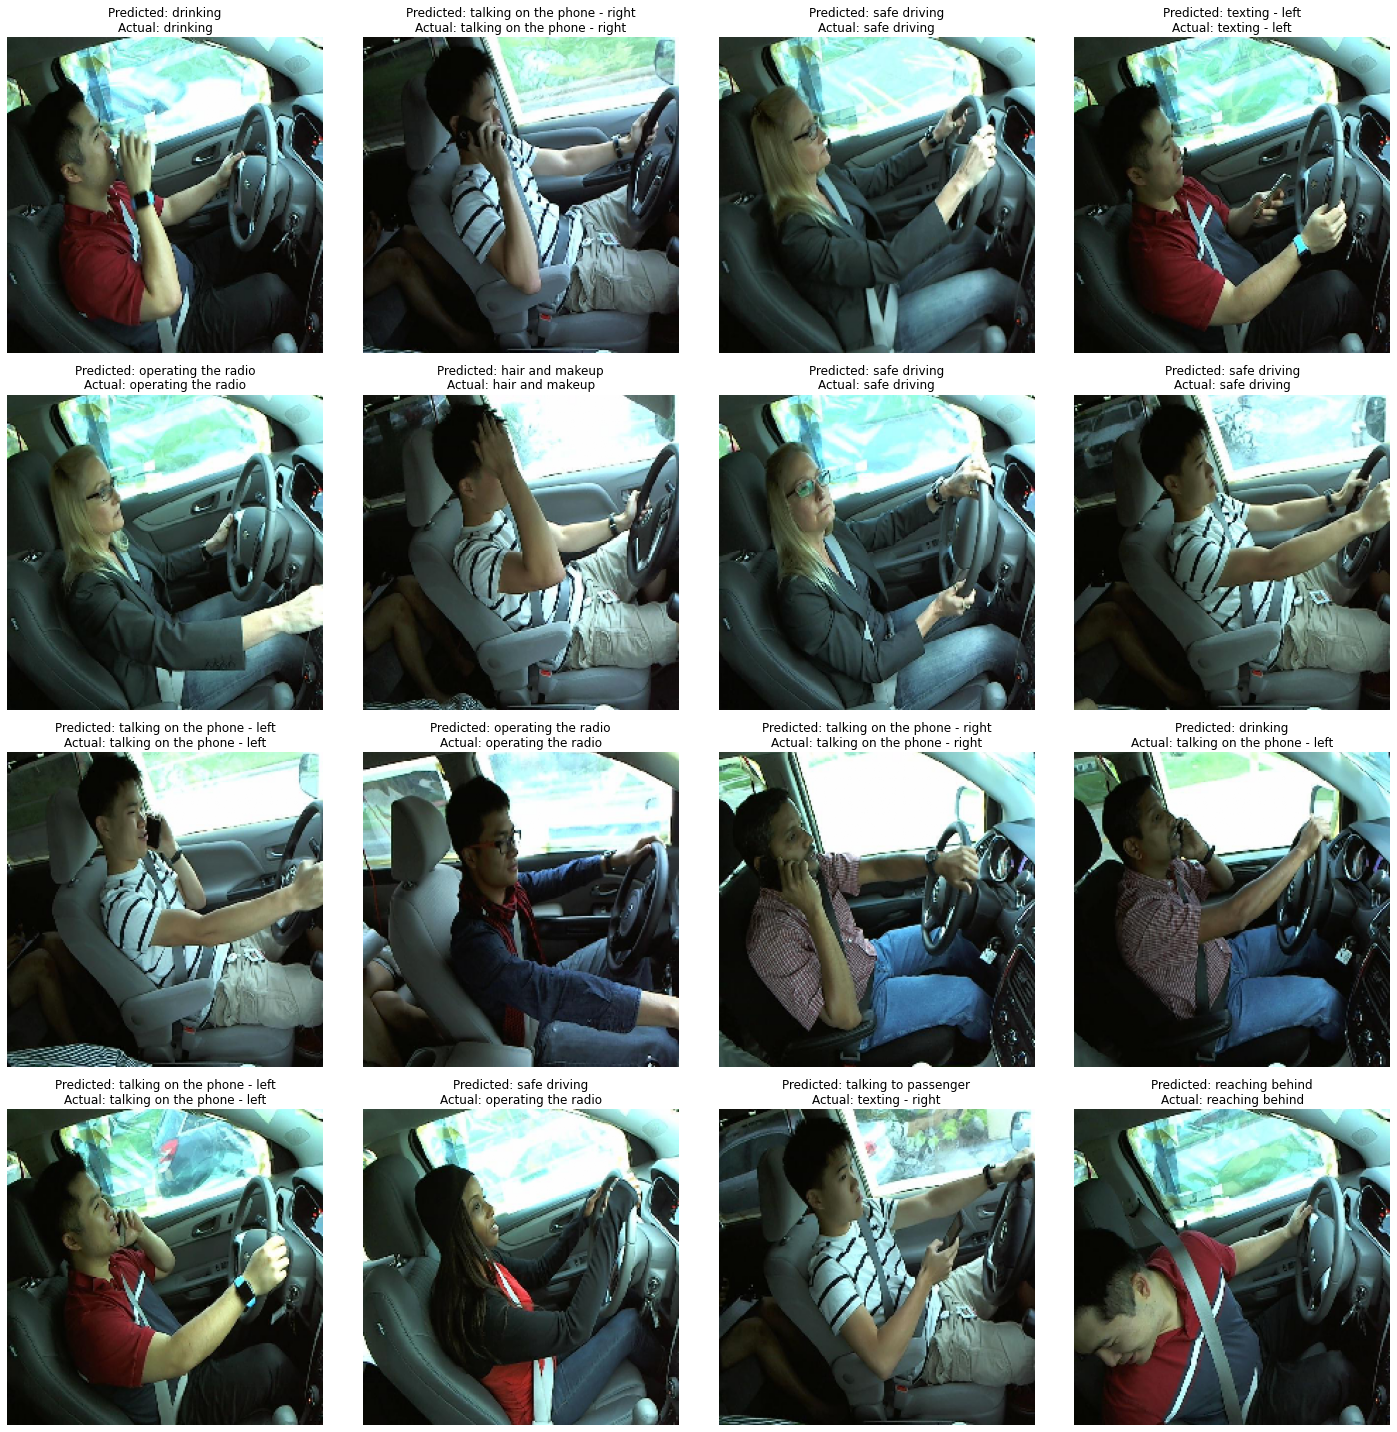

In [69]:
# Using Matplotlib.pyplot to visualize the predictions
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for img, pred, act, ax in zip(images[:16], output[:16], actual[:16], axes):  # Displaying only 16 images
    ax.imshow(img/255.0)
    ax.axis('off')
    ax.set_title(f"Predicted: {pred}\nActual: {act}")

plt.tight_layout()
plt.show()

# Conclusions

__Before Fine Tuning:__  
Achieved Val_Accuracy = 0.7244  
Achieved Accuracy = 0.7950  

__After Fine Tuning:__  
Achieved Val_Accuracy = 0.8390920162200928  
Achieved Accuracy = 0.9737  

Upon careful observations, there are a few incorrect labels in the dataset, which leads to lower model val_accuracy.  